# Verkehrsmittelwahl

### Dataset

https://www.data.gv.at/katalog/dataset/3e9af1f2-9333-4c1c-978f-9a0c6771fce3#additional-info

- Bezirklevel
- 2002-2023

= Registered Vehicled / per 1000 inhabitants:
- CAR
- LKW

## Prepare Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#### PAST Data

In [3]:

# Load past population (2000–2023)
past = pd.read_csv("../data_arima_raw/population_past.csv", sep=";")
# Keep only year, district code, and total population
past = past[["REF_YEAR", "DISTRICT_CODE", "POP_TOTAL"]].copy()
# Filter to years 2000 through 2023
past = past[past["REF_YEAR"].between(2000, 2023)]
# Rename POP_TOTAL → POP for consistency
past = past.rename(columns={"POP_TOTAL": "POP"})

#### Forecasted Data

In [5]:
# Load forecasted population (2024–2030)
fcast = pd.read_csv("../data_arima_raw/population_forecast.csv", sep=";")
# Keep only year, district code, and projected population
fcast = fcast[["REF_YEAR", "DISTRICT_CODE", "POP"]].copy()
# Filter to years 2024 through 2030
fcast = fcast[fcast["REF_YEAR"].between(2024, 2030)]
# Convert “POP” from strings like “16 620,00” → float 16620.00
fcast["POP"] = (
    fcast["POP"]
    .str.replace(r"\.", "", regex=True)    # remove thousands separator
    .str.replace(",", ".", regex=False)    # decimal comma to dot
    .astype(float)
)

#### Combine

In [7]:

# Combine past and forecast into one long table
pop_ann = pd.concat([past, fcast], ignore_index=True)

# Map DISTRICT_CODE (e.g. 90100) → Viennese PLZ (e.g. 1010)
def code_to_plz(code):
    dnum = (int(code) % 10000) // 100
    return int(f"1{dnum:02d}0")

pop_ann["BEZIRK"] = pop_ann["DISTRICT_CODE"].apply(code_to_plz)

# Create a datetime column for January 1 of each REF_YEAR
pop_ann["DATE"] = pd.to_datetime(pop_ann["REF_YEAR"].astype(str) + "-01-01")

# Keep only DATE, BEZIRK, and POP
pop_ann = pop_ann[["DATE", "BEZIRK", "POP"]]

In [8]:
# Now upsample each district’s annual population to a monthly series (Jan 2000–Dec 2030)
monthly_list = []

for bezirk, group in pop_ann.groupby("BEZIRK"):
    # Build an annual series indexed by DATE for this district
    annual = group.set_index("DATE").sort_index().asfreq("YS")
    
    # Full annual index 2000–2030
    full_idx = pd.date_range("2000-01-01", "2030-01-01", freq="YS")
    full_ann = pd.DataFrame(index=full_idx, columns=["POP"], dtype=float)
    full_ann.loc[annual.index, "POP"] = annual["POP"].values
    
    # Upsample to month-end and forward-fill
    monthly = full_ann.resample("ME").ffill()
    
    # Ensure every month between Jan 2000 and Dec 2030 is present
    all_month_ends = pd.date_range("2000-01-31", "2030-12-31", freq="ME")
    monthly = monthly.reindex(all_month_ends).ffill()
    
    # Convert index from month-end → month-start
    monthly.index = monthly.index.to_period("M").to_timestamp()
    
    # Clip any negative values (just in case) to zero
    monthly = monthly.clip(lower=0)
    
    # Add the district (BEZIRK) and reset index so DATE becomes a column
    monthly["BEZIRK"] = bezirk
    monthly = monthly.reset_index().rename(columns={"index": "DATE"})
    
    # Keep only DATE, BEZIRK, and POP
    monthly = monthly[["DATE", "BEZIRK", "POP"]]
    monthly_list.append(monthly)


In [9]:
# Concatenate all districts into one long DataFrame
pop_monthly_long = pd.concat(monthly_list, ignore_index=True)

In [11]:
# Filter out any rows where the year is 2000
pop_monthly_long = pop_monthly_long[pop_monthly_long["DATE"].dt.year != 2000]

# Verify
print(pop_monthly_long["DATE"].min(), pop_monthly_long["DATE"].max())

2001-01-01 00:00:00 2030-12-01 00:00:00


In [12]:
pop_monthly_long.head()

,DATE,BEZIRK,POP
12,2001-01-01,1010,17056.0
13,2001-02-01,1010,17056.0
14,2001-03-01,1010,17056.0
15,2001-04-01,1010,17056.0
16,2001-05-01,1010,17056.0


In [14]:
# Save to CSV for later merging
output_path = "../data_arima_final/population_by_bezirk.csv"
pop_monthly_long.to_csv(output_path, index=False)

#### Plot

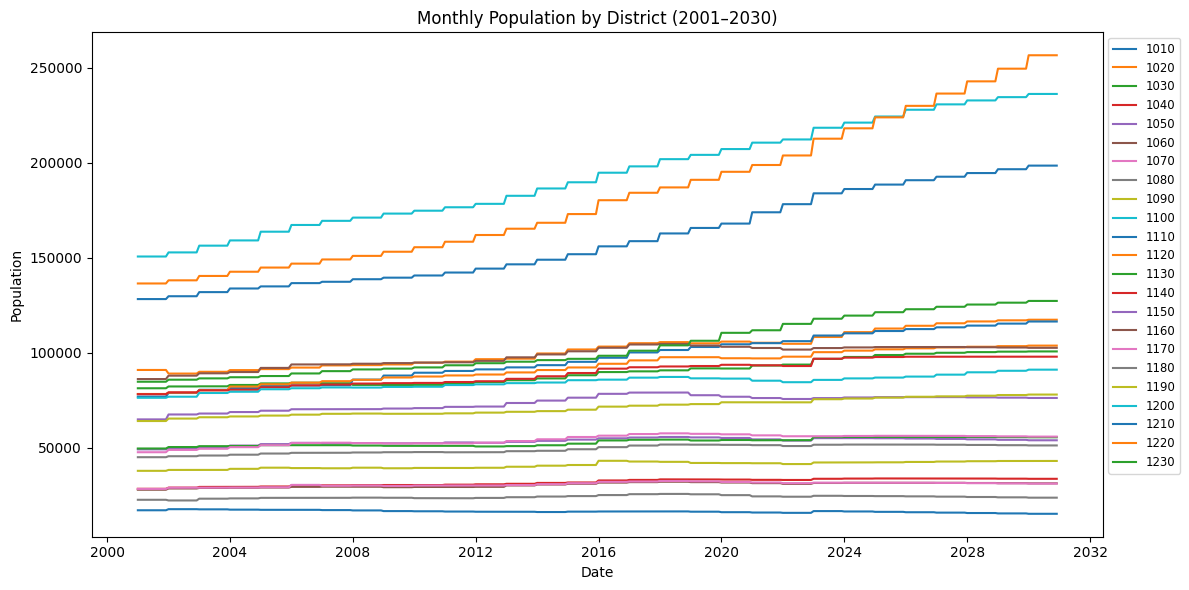

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the long‐form population CSV if not already in memory
pop_monthly_long = pd.read_csv("../data_arima_final/population_by_bezirk.csv", parse_dates=["DATE"])

# Pivot so each district becomes a column, indexed by DATE, with population values
pop_wide = pop_monthly_long.pivot(index="DATE", columns="BEZIRK", values="POP")

# Plot one line per district showing population over time
plt.figure(figsize=(12, 6))
for bezirk in pop_wide.columns:
    plt.plot(pop_wide.index, pop_wide[bezirk], label=str(bezirk))

plt.title("Monthly Population by District (2001–2030)")
plt.xlabel("Date")
plt.ylabel("Population")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
plt.tight_layout()
plt.show()
